<a href="https://colab.research.google.com/github/ritikumra/Lung-Cancer-Patient-Follow-Up-Prediction/blob/main/Oncology_Patients_Follow_Up_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

In [5]:
df = pd.read_csv("/content/LungNodule_Corrected_Comorbidities.csv")

# Encode categorical columns
label_encoders = {}
categorical_cols = ['AgeGroup', 'FamilyHistoryCancer',
                    'SelfHistoryCancer']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize numerical features
scaler = MinMaxScaler()
df[['SmokingPackYears', 'NoduleSize_mm']] = scaler.fit_transform(df[['SmokingPackYears', 'NoduleSize_mm']])

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')


# Sort for sequence alignment
df = df.sort_values(by=['PatientID', 'FollowUpNumber'])

df['SmokingPackYears']
df['NoduleSize_mm']

,NoduleSize_mm
0,0.426523
1,0.426523
2,0.426523
3,0.473118
4,0.473118
...,...
4995,0.318996
4996,0.390681
4997,0.462366
4998,0.440860


In [6]:


# Encode all categorical columns
df_encoded = df.copy()
for col in ['AgeGroup', 'FamilyHistoryCancer', 'SelfHistoryCancer']:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Drop non-feature columns for X
features_df = df_encoded.drop(['PatientID', 'FollowUpNumber', 'FollowUpInterval'], axis=1)

for index, label in enumerate(label_encoders['AgeGroup'].classes_):
    print(f"{index}: {label}")




0: 20-30
1: 30-40
2: 40-50
3: 50-60
4: 60-70
5: 70-80
6: 80-90


In [7]:
df

,PatientID,AgeGroup,Comorbidities,FamilyHistoryCancer,SelfHistoryCancer,SmokingPackYears,FollowUpNumber,NoduleType,NoduleSize_mm,LungRadScore,FollowUpInterval
0,P0001,4,1,0,0,0.190141,1,2,0.426523,5,Immediate evaluation
1,P0001,4,1,0,0,0.190141,2,2,0.426523,2,12 months
2,P0001,4,1,0,0,0.190141,3,2,0.426523,2,12 months
3,P0001,4,1,0,0,0.190141,4,2,0.473118,5,Immediate evaluation
4,P0001,4,1,0,0,0.190141,5,2,0.473118,2,12 months
...,...,...,...,...,...,...,...,...,...,...,...
4995,P1000,3,0,1,0,0.253521,1,1,0.318996,2,12 months
4996,P1000,3,0,1,0,0.253521,2,1,0.390681,2,12 months
4997,P1000,3,0,1,0,0.253521,3,1,0.462366,2,12 months
4998,P1000,3,0,1,0,0.253521,4,1,0.440860,2,12 months


In [8]:
import numpy as np

# Group by PatientID and create sequences
grouped = df_encoded.groupby('PatientID')

X_sequences = []
for pid, group in grouped:
    group_sorted = group.sort_values(by='FollowUpNumber')
    features = group_sorted.drop(['PatientID', 'FollowUpInterval'], axis=1).values
    X_sequences.append(features)

# Pad sequences to the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_padded = pad_sequences(X_sequences, padding='post', dtype='float32')  # shape: (n_patients, max_seq_len, n_features)


In [9]:
df['FollowUpInterval']

,FollowUpInterval
0,Immediate evaluation
1,12 months
2,12 months
3,Immediate evaluation
4,12 months
...,...
4995,12 months
4996,12 months
4997,12 months
4998,12 months


In [10]:
# Get last follow-up interval for each patient
y_labels = grouped.tail(1)['FollowUpInterval'].values

# Encode follow-up intervals (e.g., '3 months', '12 months')
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y_labels)

# Convert to one-hot
from tensorflow.keras.utils import to_categorical
y_onehot = to_categorical(y_encoded)

for index, label in enumerate(le_y.classes_):
    print(f"{index}: {label}")

0: 12 months
1: 3 months
2: 6 months
3: Immediate evaluation


In [11]:
df['FollowUpInterval'].value_counts()


,count
FollowUpInterval,
12 months,2665
Immediate evaluation,977
6 months,746
3 months,612


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_onehot, test_size=0.2, random_state=42
)

# Get shapes
timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = y_onehot.shape[1]
print(features)


9


In [13]:
print(X_train.shape)


(800, 5, 9)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, features)))  # 1st LSTM layer
model.add(LSTM(64, return_sequences=True))                                      # 2nd LSTM layer
model.add(LSTM(32))                                                             # 3rd LSTM layer (last one)
model.add(Dense(num_classes, activation='softmax'))                             # Output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=40, batch_size=10, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5809 - loss: 1.1742 - val_accuracy: 0.5500 - val_loss: 1.1545
Epoch 2/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5980 - loss: 1.0981 - val_accuracy: 0.5500 - val_loss: 1.0777
Epoch 3/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5755 - loss: 1.0687 - val_accuracy: 0.5688 - val_loss: 1.0219
Epoch 4/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6149 - loss: 0.9490 - val_accuracy: 0.5625 - val_loss: 0.9799
Epoch 5/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7322 - loss: 0.7586 - val_accuracy: 0.7563 - val_loss: 0.5914
Epoch 6/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8989 - loss: 0.3659 - val_accuracy: 0.9750 - val_loss: 0.2198
Epoch 7/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9691 - loss: 0.1856 - val_accuracy: 0.9563 - val_loss: 0.1684
Epoch 8/40
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9838 - loss: 0.1240 - val_accuracy: 0.9937 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


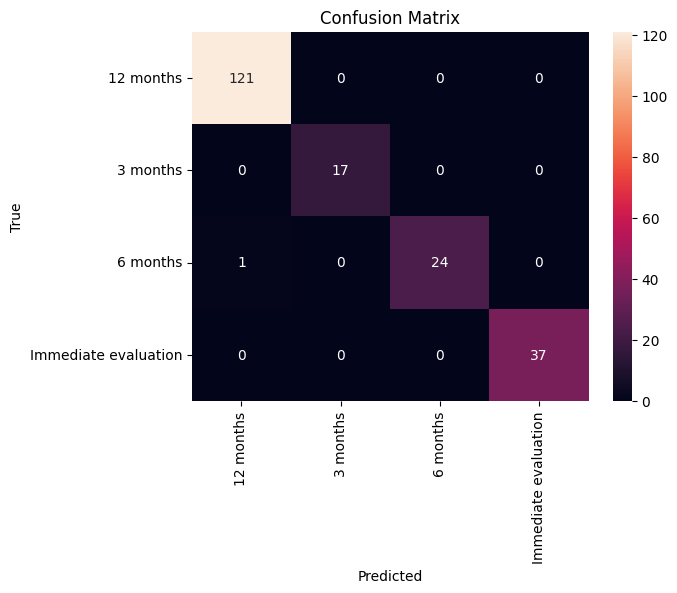

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Decode to original labels
y_pred_labels = le_y.inverse_transform(y_pred)
y_true_labels = le_y.inverse_transform(y_true)

# Plot confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le_y.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
print(classification_report(y_true_labels, y_pred_labels))


                      precision    recall  f1-score   support

           12 months       0.99      1.00      1.00       121
            3 months       1.00      1.00      1.00        17
            6 months       1.00      0.96      0.98        25
Immediate evaluation       1.00      1.00      1.00        37

            accuracy                           0.99       200
           macro avg       1.00      0.99      0.99       200
        weighted avg       1.00      0.99      0.99       200



In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,838 (1.52 MB)

 Trainable params: 132,612 (518.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 265,226 (1.01 MB)

In [18]:
model.save("followup_lstm_model.h5", include_optimizer=False)


In [19]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00


In [20]:
# example saving
import joblib
joblib.dump(model, 'model.pkl')


['model.pkl']

In [21]:
joblib.dump(le_y, 'label_encoder.pkl')


['label_encoder.pkl']

In [22]:
!pip install streamlit pyngrok --quiet


In [23]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Replace this list with the actual list of follow-up labels used
labels = ["Immediate Evaluation", "3 months", "6 months", "12 months"]

le = LabelEncoder()
le.fit(labels)

# Save it
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [134]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib

# Load the trained model
@st.cache_resource
def load_model():
  return tf.keras.models.load_model('followup_lstm_model.h5', compile=False)

model = load_model()

# Load label encoder used during training
with open('label_encoder.pkl', 'rb') as file:
    le = pickle.load(file)

# Load the scaler used for numerical features
scaler = joblib.load('scaler.pkl')


st.title("Follow-Up Interval Predictor")

# Get the expected input shape from the model
timesteps = int(model.input_shape[1])
features = int(model.input_shape[2])

st.write(f"The model was trained on sequences of length {timesteps}. You can enter data for up to {timesteps} follow-ups.")

# Get the number of follow-ups from the user
num_follow_ups = st.number_input("Enter the number of follow-ups:", min_value=1, max_value=timesteps, value=1, step=1)

# Collect input for the specified number of follow-ups
patient_sequence_data = []
for i in range(num_follow_ups):
    st.subheader(f"Follow-Up {i+1}")
    age_group = st.selectbox(f"Age Group (Follow-Up {i+1})", ['20-30', '30-40', '40-50', '50-60', '60-70','70-80','80-90'], key=f'age_{i}')
    comorbidities = st.number_input(f"Number of Comorbidities (Follow-Up {i+1})", min_value=0, max_value=5, step=1, key=f'comorb_{i}')
    family_history = st.selectbox(f"Family History of Cancer (Follow-Up {i+1})", ['Yes', 'No'], key=f'fam_hist_{i}')
    self_history = st.selectbox(f"Self History of Cancer (Follow-Up {i+1})", ['Yes', 'No'], key=f'self_hist_{i}')
    smoking_pack_years = st.number_input(f"Smoking Pack Years (Follow-Up {i+1})", min_value=0.0, max_value=100.0, step=1.0, key=f'smoking_{i}')
    nodule_type= st.selectbox(f"Nodule Type (Follow-Up {i+1})",['Solid','Part-Solid','Non-Solid'], key=f'nodule_type_{i}')
    nodule_size = st.number_input(f"Nodule Size (mm) (Follow-Up {i+1})", min_value=0.0, max_value=100.0, step=0.1, key=f'nodule_size_{i}')
    lung_rad_score = st.selectbox(f"Lung-RADS Score (Follow-Up {i+1})", [2, 3, 4, 5], key=f'lungrads_{i}')

    # Scale the numerical inputs
    # Reshape input for scaler: scaler expects a 2D array where each row is a sample and each column is a feature.
    # We are scaling smoking_pack_years and nodule_size together, so input shape is (1, 2)
    scaled_features = scaler.transform([[smoking_pack_years, nodule_size]])
    scaled_smoking = scaled_features[0][0]
    scaled_nodule_size = scaled_features[0][1]


    # Store the features for this follow-up
    # Map categorical inputs to numerical as per training encoding
    age_map = {'20-30': 0, '30-40': 1, '40-50': 2, '50-60': 3, '60-70': 4,'70-80': 5, '80-90': 6 }
    yes_no_map = {'Yes': 1, 'No': 0}
    nodule_type_map = {'Solid': 3, 'Part-Solid': 2, 'Non-Solid': 1}


    features_list = [
        age_map[age_group],
        comorbidities,
        yes_no_map[family_history],
        yes_no_map[self_history],
        scaled_smoking,
        i + 1, # Follow-up number
        nodule_type_map[nodule_type],
        scaled_nodule_size,
        lung_rad_score
    ]
    patient_sequence_data.append(features_list)


if st.button("Predict Follow-Up Interval"):
    # Convert collected data to numpy array
    input_sequence = np.array(patient_sequence_data, dtype=np.float32)

    # Pad or truncate the sequence to match the model's timesteps
    if input_sequence.shape[0] < timesteps:
        num_padding_rows = timesteps - input_sequence.shape[0]
        #padding_shape = (num_padding_rows, features)
        #padding = np.zeros(padding_shape, dtype=np.float32)
        padding_row = [0] * features
        padding = np.array([padding_row] * num_padding_rows, dtype=np.float32)
        input_data = np.concatenate((padding,input_sequence), axis=0)
    elif input_sequence.shape[0] > timesteps:
        input_data = input_sequence[-timesteps:, :]
    else:
        input_data = input_sequence


    # Reshape for prediction: (1, timesteps, features)
    input_data = input_data.reshape((1, timesteps, features))

    # Assuming class_map is already defined from previous cells or define it here
    # class_map = {0: "12 months", 1: "3 months", 2: "6 months", 3: "immediate evaluation"}
    # Using the loaded label encoder to get the class names
    class_map = {i: label for i, label in enumerate(le.classes_)}


    # Predict class probabilities
    prediction = model.predict(input_data)
    predicted_class = np.argmax(prediction)

    st.success(f"🩺 Recommended Follow-Up Interval: *{class_map[predicted_class]}*")

Overwriting app.py


In [135]:
!ngrok config add-authtoken 308VpnoOCO5xxbiQbV27aS9sRVb_6n46jDAS3Nzupn4QjJsYL

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [136]:
from pyngrok import ngrok
ngrok.kill()

In [137]:
import os
os.system("streamlit run app.py --server.port 8555 &")

0

In [139]:
public_url = ngrok.connect(8555)
print(f"🔗 Your Streamlit app is live at: {public_url}")

🔗 Your Streamlit app is live at: NgrokTunnel: "https://db9314f12572.ngrok-free.app" -> "http://localhost:8555"


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("followup_lstm_model.h5")
model.summary()

print("Expected model input shape:", model.input_shape)



In [ ]:
!ls -l /content


In [ ]:
df

In [112]:

patient_sequence_data = [
    [2, 1, 0, 0, 0.47591, 1, 1, 0.466666, 3], # Follow-up 1
    #[2, 1, 0, 0, 0.450000, 2, 1, 0.266666, 2], # Follow-up 2
    #[2, 1, 0, 0, 0.450141, 3, 2, 0.426523, 4], # Follow-up 3
    #[2, 1, 0, 1, 0.190141, 4, 2, 0.180000, 2], # Follow-up 4
   # [2, 0, 0, 0, 0.190141, 5, 2, 0.787700, 5]  # Follow-up 5
]


timesteps = model.input_shape[1]
features = model.input_shape[2]

if len(patient_sequence_data) > timesteps:
    # Trim the sequence if it's longer than the model's timesteps
    input_data = np.array(patient_sequence_data[-timesteps:], dtype=np.float32)
elif len(patient_sequence_data) < timesteps:
    # Pad the sequence if it's shorter than the model's timesteps
    padding_shape = (timesteps - len(patient_sequence_data), features)
    padding = np.zeros(padding_shape, dtype=np.float32) # or use a masking layer in the model
    input_data = np.concatenate((padding, np.array(patient_sequence_data, dtype=np.float32)), axis=0)
else:
    input_data = np.array(patient_sequence_data, dtype=np.float32)


input_data = input_data.reshape((1, timesteps, features))

# Assuming class_map is already defined from previous cells
class_map = {0: "12 months", 1: "3 months", 2: "6 months", 3: "immediate evaluation"}

prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)

print("Predicted Probabilities:", prediction)
print("Predicted Follow-Up Interval:", class_map[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Probabilities: [[0.04677977 0.06865057 0.02394823 0.86062145]]
Predicted Follow-Up Interval: immediate evaluation


In [111]:

patient_sequence_data = [
    #[4, 1, 0, 0, 0.475911, 1, 1, 0.156666, 2], # Follow-up 1
    #[4, 1, 0, 0, 0.450000, 2, 2, 0.266666, 3], # Follow-up 2
    #[4, 1, 0, 1, 0.450141, 3, 2, 0.126523, 2], # Follow-up 3
    #[4, 1, 0, 1, 0.190141, 4, 2, 0.100000, 2], # Follow-up 4
   # [2, 0, 0, 0, 0.190141, 5, 2, 0.787700, 5]  # Follow-up 5
]


# Ensure the sequence length matches the model's expected input shape (timesteps)
timesteps = model.input_shape[1]
features = model.input_shape[2]

if len(patient_sequence_data) > timesteps:
    # Trim the sequence if it's longer than the model's timesteps
    input_data = np.array(patient_sequence_data[-timesteps:], dtype=np.float32)
elif len(patient_sequence_data) < timesteps:
    # Pad the sequence if it's shorter than the model's timesteps
    padding_shape = (timesteps - len(patient_sequence_data), features)
    padding = np.zeros(padding_shape, dtype=np.float32) # or use a masking layer in the model
    input_data = np.concatenate((padding, np.array(patient_sequence_data, dtype=np.float32)), axis=0)
else:
    input_data = np.array(patient_sequence_data, dtype=np.float32)


input_data = input_data.reshape((1, timesteps, features))

# Assuming class_map is already defined from previous cells
class_map = {0: "12 months", 1: "3 months", 2: "6 months", 3: "immediate evaluation"}


prediction = model.predict(input_data)
predicted_class = np.argmax(prediction)

print("Predicted Probabilities:", prediction)
print("Predicted Follow-Up Interval:", class_map[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Probabilities: [[6.1116309e-04 2.2969950e-02 1.1377442e-03 9.7528118e-01]]
Predicted Follow-Up Interval: immediate evaluation


In [ ]:
scaler = MinMaxScaler()
max = 100;
min = 0;
scaled = 10



In [103]:
def load_model():
  return tf.keras.models.load_model('followup_lstm_model.h5', compile=False)

model = load_model()

# Load label encoder used during training
with open('label_encoder.pkl', 'rb') as file:
    le = pickle.load(file)

# Load the scaler used for numerical features
scaler = joblib.load('scaler.pkl')


st.title("Lung Follow-Up Interval Predictor")

# Get the expected input shape from the model
timesteps = int(model.input_shape[1])
features = int(model.input_shape[2])
timesteps



2025-07-22 09:03:28.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 09:03:28.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-22 09:03:28.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


5